In [1]:
import torch

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

import matplotlib.pyplot as plt

from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx

### [Zachary's Karate Club](https://en.wikipedia.org/wiki/Zachary's_karate_club) Dataset

In [2]:
from torch_geometric.datasets import KarateClub

kc = KarateClub().get(0)
edge_index = kc.edge_index
labels = kc.y

# construct sparse adjacency matrix from edge index
data = torch.sparse_coo_tensor(
    indices = edge_index,
    values = torch.ones(edge_index.shape[-1]),
    size = [34, 34]
)

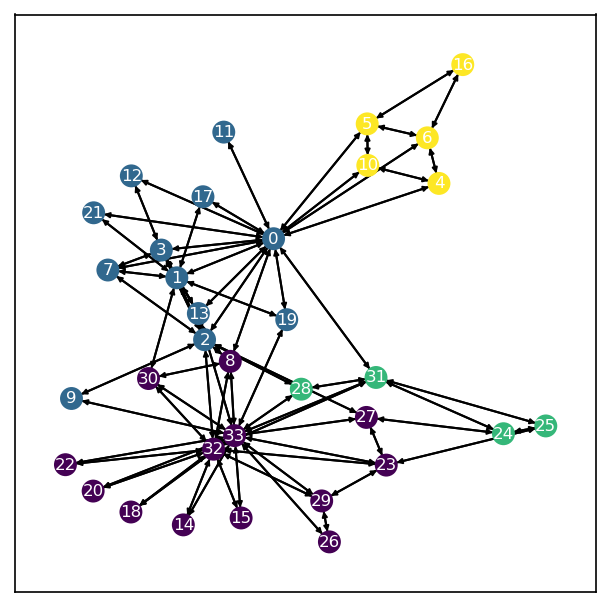

In [3]:
G = to_networkx(Data(edge_index=edge_index, num_nodes=34))
fig, ax = plt.subplots(1,1,figsize=(5,5), dpi=150)
nx.draw_networkx(
    G,
    pos=nx.spring_layout(G, seed=42),
    node_color = labels,
    
    with_labels=True,
    font_size=8,
    font_color='white',
    
    arrows=True,
    arrowsize=5,
    node_size=100,

    ax=ax,
)

### fastRG graph sampling (https://arxiv.org/pdf/1703.02998.pdf)
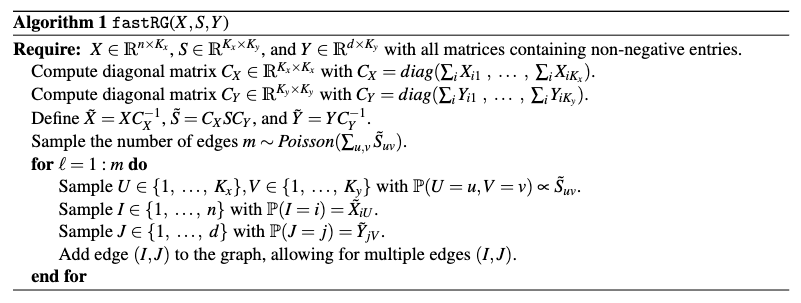

In [4]:
class SBM(dist.TorchDistribution):
    def __init__(self, X, S, Y=None):
        
        # no batch shape given
        if len(X.shape) == 2:
            self.n_nodes, self.n_blocks = X.shape
            batch_shape = torch.Size([])
            
        # batch shape given
        elif len(X.shape) == 3:
            n_batches, self.n_nodes, self.n_blocks = X.shape
            batch_shape = torch.Size([n_batches])
            
        else:
            raise ValueError("X must be 2D or 3D")

        super().__init__(
            batch_shape = batch_shape,
            event_shape = torch.Size([self.n_nodes, self.n_nodes]),
            validate_args=False
        )
        
        # block connection probabilities
        assert S.shape == self.batch_shape + torch.Size([self.n_blocks, self.n_blocks])
        
        # add empty batch dimension if none given
        if len(X.shape) == 2:
            self.X = X.unsqueeze(0)
            self.S = S.unsqueeze(0)
        else:
            self.X = X
            self.S = S
        
        # sink node membership matrix (same as X by default)
        if Y is not None:
            self.Y = Y
            assert self.Y.shape == self.X.shape, "X and Y must have same shape"
            
        else:
            self.Y = self.X
            
        # log expectation matrices
        self.log_expectation = torch.matmul(self.X, torch.matmul(self.S, self.X.transpose(-1,-2))).log()
            
        # membership count matrices (sum along node dimension)
        CX = torch.stack(
            tuple(map(torch.diag, self.X.sum(1)))
        )
        CY = torch.stack(
            tuple(map(torch.diag, self.Y.sum(1)))
        )
        
        # membership probabilitites
        self.Xtilde = torch.matmul(self.X, torch.inverse(CX))
        self.Ytilde = torch.matmul(self.Y, torch.inverse(CY))
                
        # block degree matrix
        self.Stilde = torch.matmul(CX, torch.matmul(self.S, CY))
        
        # distributions
        self.num_edge_dist = dist.Poisson(self.Stilde.sum([1,2]))
        self.block_dist = dist.Multinomial(probs=self.Stilde.flatten(1))
        
        
    def sample(self, sample_shape=torch.Size()):
        
        sample_shape = torch.Size(sample_shape)
        assert len(sample_shape) in [0, 1], "only 0D or 1D sampling supported"

        # number of edges per sample
        num_edges = self.num_edge_dist.sample(sample_shape).int()
        
        if len(sample_shape) == 0:
            num_edges = num_edges.unsqueeze(0)
        
        tot_edges_per_batch = num_edges.sum(0)
        max_edges_per_batch = tot_edges_per_batch.max()
                
        # sample block selections for each edge
        blocks = self.block_dist.sample(max_edges_per_batch.unsqueeze(0))
        
        # create block selection matrices
        blocks = blocks.reshape(
            torch.Size([max_edges_per_batch]) +
            torch.Size([self.batch_shape.numel()]) +
            torch.Size([self.n_blocks]*2)
        )
                
        # select node probabilities for each edge
        source_probs = torch.matmul(self.Xtilde, blocks).sum(-1)
        sink_probs = torch.matmul(blocks, self.Ytilde.transpose(-1, -2)).sum(-2)
                
        # sample node selections for each edge
        sources = dist.Categorical(source_probs).sample()
        sinks = dist.Categorical(sink_probs).sample()
                
        # construct edge lists for each sample and batch
        coords = []
        for batch_coo in range(self.batch_shape.numel()):
            
            tot_edges = tot_edges_per_batch[batch_coo]
            n_edges = num_edges[:, batch_coo]
            
            # slice out edges for this batch
            edges = torch.stack([
                sources[:tot_edges, batch_coo],
                sinks[:tot_edges, batch_coo]
            ])
            
            # split edges into samples
            edge_lists = torch.split(edges, tuple(n_edges), -1)
            
            # construct 4-D (sample, batch, source, sink) coordinates
            for sample_coo, edge_list in enumerate(edge_lists):
                n = edge_list.shape[-1]
                coords.append(
                    torch.concat([
                        torch.Tensor([sample_coo]).int().expand([1, n]),
                        torch.Tensor([batch_coo]).int().expand([1, n]),
                        edge_list
                    ])
                )
                
        coords = torch.concat(coords, -1)
                
        # remove unused coordinates
        if len(sample_shape) == 0 and len(self.batch_shape) == 0:
            coords = coords[[2,3], :]
        elif len(sample_shape) == 0:
            coords = coords[[1,2,3], :]
        elif len(self.batch_shape) == 0:
            coords = coords[[0,2,3], :]
        
        # construct sparse (n_nodes * n_nodes) adjacency matrices
        return torch.sparse_coo_tensor(
            indices = coords,
            values = torch.ones(coords.shape[-1]),
            size = self.shape(sample_shape)
        )

    def log_prob(self, x):
        
        assert x.layout == torch.sparse_coo, "x must be a sparse coordinate tensor"
        
        assert len(x.shape) in [2,3,4], "invalid x shape"
        
        if len(x.shape) == 2:
            n_i, n_j = x.shape
            n_samples = 1
            n_batches = 1
            
        elif len(x.shape) == 3:
            n_x, n_i, n_j = x.shape
            if n_x == self.batch_shape.numel():
                n_batches = n_x
                n_samples = 1
            else:
                n_batches = 1
                n_samples = n_x
                
        elif len(x.shape) == 4:
            n_samples, n_batches, n_i, n_j = x.shape
            assert n_batches == self.batch_shape.numel(), "x does not match distribution batch shape"
            
        assert n_i == self.n_nodes and n_j == self.n_nodes, "x does not match distribution event shape"
            

        # sort coordinates
        if not x.is_coalesced():
            x = x.coalesce()
        
        coords = x.indices()
        
        # [i,j] -> [1, 1, i, j]
        if len(x.shape) == 2:
            coords = torch.concat([
                torch.zeros(1, coords.shape[-1], dtype=int),
                torch.zeros(1, coords.shape[-1], dtype=int),
                coords
            ])
        
        # [batch, i, j] -> [1, batch, i, j]
        elif len(x.shape) == 3 and n_samples == 1:
            coords = torch.concat([
                torch.zeros(1, coords.shape[-1], dtype=int),
                coords
            ])
        
        # [sample, i, j] -> [sample, 1, i, j]:
        elif len(x.shape) == 3 and n_samples > 1:
            coords = torch.concat([
                coords[[0],:],
                torch.zeros(1, coords.shape[-1], dtype=int),
                coords[[1,2], :]
                
            ])         
        
        # initialize
        scores = torch.zeros([n_samples, n_batches])
        n_edges = torch.zeros([n_samples, n_batches])
        
        current_batch = 0
        current_batch_obs = {}
        
        for sample_coo, batch_coo, source, sink in coords.T:
            
            # when batch changes, clear set of observed edges
            if batch_coo != current_batch:
                current_batch_obs = {}
                current_batch = batch_coo
            
            # only score each edge once
            if not current_batch_obs.get((source, sink)):
                scores[sample_coo, batch_coo] += self.log_expectation[batch_coo, source, sink]
                current_batch_obs[(source, sink)] = True
                
            # count total number of edges
            n_edges[sample_coo, batch_coo] += 1
            
        # add score from poisson distribution
        scores += self.num_edge_dist.log_prob(n_edges)
            
        # remove sample and batch dimensions for single event
        if len(x.shape) == 2:
            scores = scores.squeeze([0,1])
            
        # remove batch dimension for multiple events with no batch shape
        elif len(x.shape) == 3 and len(self.batch_shape) == 0:
            scores = scores.squeeze(1)
            
        # remove sample dimension for multiple events with no sample shape
        elif len(x.shape) == 3 and n_samples == 1:
            scores = scores.squeeze(0)
            
        return scores
            

### Pyro Modeling

In [5]:
def model(edges=None):
    X = pyro.sample( "X", dist.OneHotCategorical( probs=torch.ones( [34, 2] ) / 2 ).to_event(1) )
    S = pyro.sample( "S", dist.Beta( torch.Tensor([[5, 2],[2, 5]]), torch.Tensor([[2, 5],[5, 2]]) ).to_event(2) )
    
    return pyro.sample(f"obs", SBM(X, S), obs=edges)

def guide(edges=None):
    X_logits = pyro.param("X_logits", lambda: torch.ones([34, 2]), constraint=constraints.positive)
    X = pyro.sample("X", dist.OneHotCategorical( logits = X_logits ).to_event(1) )
    
    S_alpha = pyro.param("S_alpha", lambda: torch.Tensor([[5, 2],[2, 5]]), constraint=constraints.positive)
    S_beta  = pyro.param("S_beta", lambda: torch.Tensor([[2, 5],[5, 2]]), constraint=constraints.positive)
    S = pyro.sample("S", dist.Beta(S_alpha, S_beta).to_event(2))
    
    return SBM(X, S)
    

In [7]:
pyro.clear_param_store()
optim = pyro.optim.Adagrad({"lr":0.2})
svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO()) 
for i in range(2000):
    loss = svi.step(data)
    if i % 100 == 0:
        print(i, loss)


0 362.6755065917969
100 293.03901386260986
200 290.1945285797119
300 293.29515075683594
400 274.2623698711395
500 304.42699813842773
600 274.9635863304138
700 273.48583459854126
800 285.9977478981018
900 273.6366777420044
1000 269.73648023605347
1100 289.264301776886
1200 272.9952383041382
1300 264.7251000404358
1400 268.51687240600586
1500 270.5412611961365
1600 271.565669298172
1700 276.50287342071533
1800 270.00763511657715
1900 281.1248698234558


In [8]:
X_samples = []
S_samples = []
for i in range(1000):
    sbm = guide()
    X_samples.append(sbm.X[0,:,0])
    S_samples.append(sbm.S[0])
X_samples = torch.stack(X_samples)
S_samples = torch.stack(S_samples)

In [9]:
X_samples.mean(0)

tensor([0.8810, 0.6310, 0.8410, 0.1660, 0.1690, 0.7270, 0.4920, 0.7530, 0.6380,
        0.1930, 0.7690, 0.9410, 0.2020, 0.3250, 0.1050, 0.2400, 0.6470, 0.6870,
        0.5110, 0.7310, 0.4430, 0.4370, 0.4920, 0.3960, 0.6420, 0.7410, 0.7490,
        0.3510, 0.4430, 0.2300, 0.4750, 0.2510, 0.1790, 0.3410])

In [10]:
X_samples.std(0)

tensor([0.3240, 0.4828, 0.3659, 0.3723, 0.3749, 0.4457, 0.5002, 0.4315, 0.4808,
        0.3949, 0.4217, 0.2357, 0.4017, 0.4686, 0.3067, 0.4273, 0.4781, 0.4639,
        0.5001, 0.4437, 0.4970, 0.4963, 0.5002, 0.4893, 0.4797, 0.4383, 0.4338,
        0.4775, 0.4970, 0.4210, 0.4996, 0.4338, 0.3835, 0.4743])

In [11]:
S_samples.mean(0)

tensor([[0.2999, 0.2710],
        [0.2754, 0.2764]], grad_fn=<MeanBackward1>)

In [12]:
S_samples.std(0)

tensor([[0.0876, 0.0777],
        [0.0744, 0.0814]], grad_fn=<StdBackward0>)

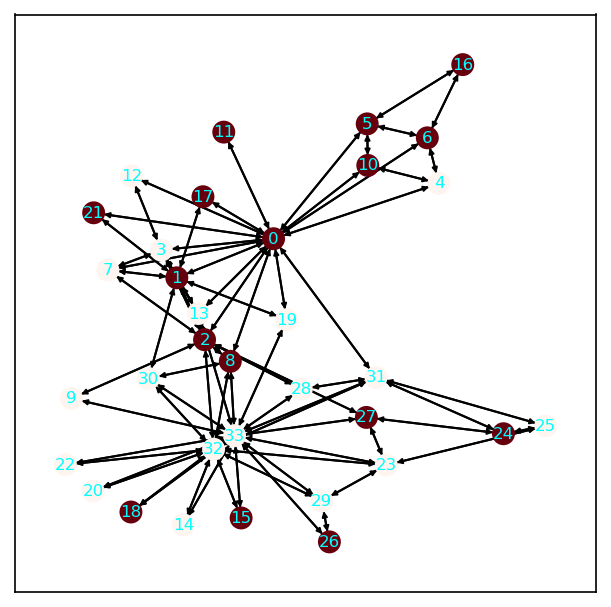

In [21]:
G = to_networkx(Data(edge_index=edge_index, num_nodes=34))
fig, ax = plt.subplots(1,1,figsize=(5,5), dpi=150)
nx.draw_networkx(
    G,
    pos=nx.spring_layout(G, seed=42),
    
    node_color = guide().X[0,:,0],

    with_labels=True,
    font_size=8,
    font_color='cyan',
    
    arrows=True,
    arrowsize=5,
    node_size=100,

    ax=ax,
    cmap=plt.cm.Reds
)